In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm import tqdm
import random
from scipy import ndimage

os.chdir("/home/phv0465/workspace/project-deliverable/code")

from models.cnn3d import CNN3D
from utils.visualization import *

## 1. Path Configuration

In [2]:
lung_path = "/projects/p32050/lung"
dose_path = "/projects/p32050/dose"
label_path = "/projects/p32050/all_stats.csv"

## 2. 3D Masked Dose Visualization

In [3]:
visualize_3d(
    lung_path=os.path.join(lung_path, "P1093_l.npy"),
    dose_path=os.path.join(dose_path, "P1093_d.npy")
)

Output()

## 3. Slice Visualization

In [4]:
lung, dose = load_sample(
    lung_path=os.path.join(lung_path, "P1093_l.npy"),
    dose_path=os.path.join(dose_path, "P1093_d.npy")
)

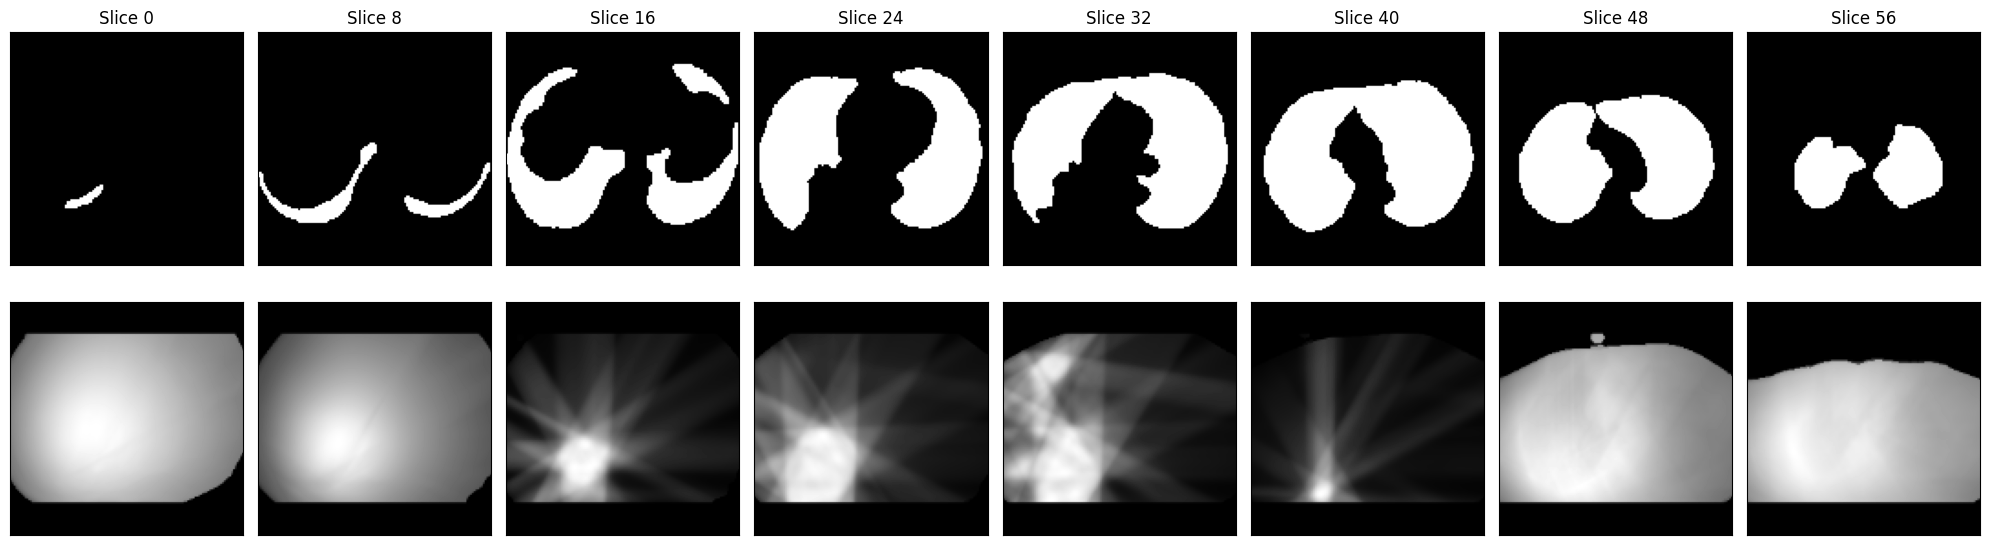

In [5]:
visualize_slice(lung, dose)

## 4. Prediction

In [6]:
model = CNN3D()
model.load_state_dict(torch.load("./results/ckpts/pneumonitis-cnn-dn2.pt", map_location='cpu'))
model.eval()

CNN3D(
  (conv1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_avg_pool): AdaptiveAvgPool3d(output_size=1)
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)

In [7]:
lung_tensor = torch.from_numpy(lung.transpose((2, 0, 1))).float().unsqueeze(0)
dose_tensor = torch.from_numpy(dose.transpose((2, 0, 1))).float().unsqueeze(0)
inputs = lung_tensor * dose_tensor

pred = model(inputs.unsqueeze(0))
print("Possibility of pneumonitis: {:.2f} %".format(pred.item() * 100))

Possibility of pneumonitis: 99.96 %


## 5. GradCAM Visualization

In [8]:
hm_conv4, hm_conv3 = run_gradcam(model, lung, dose)

/home/phv0465/.conda/envs/pytorch-1.11-py38/lib/python3.8/site-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


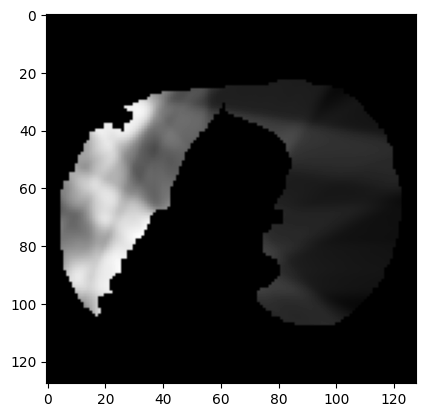

In [9]:
plt.imshow(lung[:, :, 31] * dose[:, :, 31], cmap='gray')

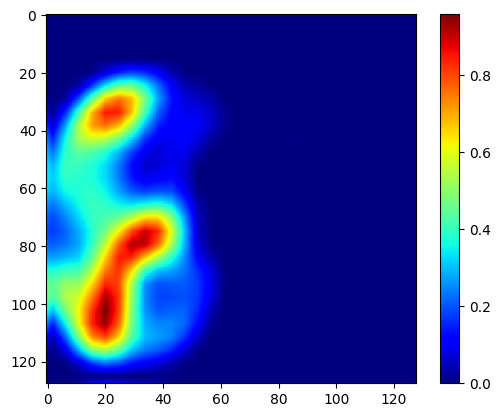

In [10]:
plt.imshow(hm_conv3, cmap='jet')
plt.colorbar()
plt.show()

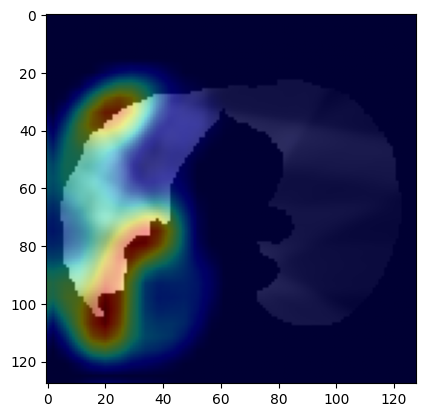

In [11]:
plt.imshow(gradcam_overlay(colorize_heatmap(hm_conv3), lung, dose))

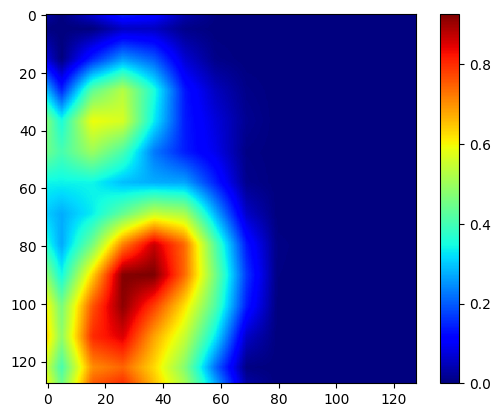

In [12]:
plt.imshow(hm_conv4, cmap='jet')
plt.colorbar()
plt.show()

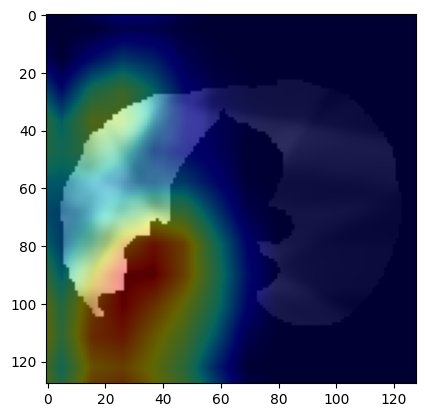

In [13]:
plt.imshow(gradcam_overlay(colorize_heatmap(hm_conv4), lung, dose))